In [ ]:
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from PIL import Image
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform
from rendering import init_renderer, rasterize_mesh
import torchvision.transforms as transforms

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

In [ ]:
device = torch.device("cuda:0")
device = torch.device('cpu')
mesh_og = load_objs_as_meshes(['data/cow_mesh/cow.obj'], device=device)

mesh = mesh_og
V = mesh.num_verts_per_mesh()[0].item()
F = mesh.num_faces_per_mesh()[0].item()

In [4]:
R, T = look_at_view_transform(dist=2, azim=150, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60).cpu()

In [86]:
from rendering import rasterize

res = 256

fragments, depth_map = rasterize(cameras, mesh, res)

In [87]:
image = Image.open('data/example/view.png').resize((res, res))
feature_tensor = to_tensor(image).permute(1, 2, 0)

In [88]:
from util import project_feature_map_to_vertices

vertex_features = project_feature_map_to_vertices(
    mesh,
    cameras,
    depth_map,
    feature_tensor
)

# face_vert_features = mesh.faces_list()[0]
face_vert_features = vertex_features[mesh.faces_list()[0]]

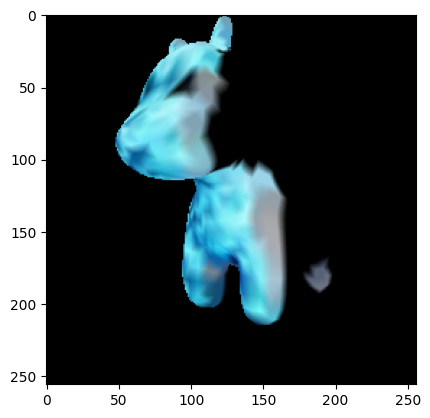

In [110]:
from rendering import rasterize_vertex_features
from einops import rearrange
from pytorch3d.ops import interpolate_face_attributes

R, T = look_at_view_transform(dist=2, azim=220, elev=0)
cam2 = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60).cpu()

pixel_features = rasterize_vertex_features(cam2, mesh, res, vertex_features)

plt.imshow(pixel_features)


In [8]:
image = Image.open('data/example/view.png').resize((res, res))
feature_tensor = to_tensor(image).permute(1, 2, 0)

In [20]:
import rerun as rr
import rerun_util as ru

rr.init('debug', spawn=True)
rr.log('/', rr.ViewCoordinates.LUF, static=True)
rr.log('/', rr.Transform3D())

rr.log('cam', ru.pt3d_FovCamera(cameras, 0, res=res))
cam_trans = cameras.get_world_to_view_transform().inverse()
rr.log('cam', ru.pt3d_transform(cam_trans))
rr.log('cam', rr.Image(depth_map.cpu().numpy()))

# log mesh
rr.log("mesh", ru.pt3d_mesh(mesh, vertex_colors=vertex_colors))


[2024-09-03T15:46:23Z INFO  re_sdk::spawn] A process is already listening at this address. Assuming it's a Rerun Viewer. addr=0.0.0.0:9876
